# RNNを利用した電力使用量 時系列データ予測

東京電力の過去の電力使用実績データ(http://www.tepco.co.jp/forecast/html/download-j.html) を利用

In [5]:
# RNNを利用した電力使用量 時系列データ予測 
%matplotlib inline
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import LSTM, GRU, SimpleRNN # LSTM 

In [6]:
from pylab import rcParams
rcParams['figure.figsize'] = 12,6      # グラフサイズ倍率  グラフおっきく

## データの読み込みと前処理

In [7]:
# データの読み込み
df = pd.read_csv('./juyo-2017-2019.csv', )
df

,DATE,HOUR,energy(10MW)
0,2017/1/1,0,2783
1,2017/1/1,1,2634
2,2017/1/1,2,2520
3,2017/1/1,3,2438
4,2017/1/1,4,2389
...,...,...,...
26275,2019/12/31,19,3302
26276,2019/12/31,20,3263
26277,2019/12/31,21,3182
26278,2019/12/31,22,3077


In [8]:
data = np.array(df)
data = data[:, 1:]         # HOURとenergy列だけを取り出す
data.astype(np.float32)    # 浮動小数点にする

array([[0.000e+00, 2.783e+03],
       [1.000e+00, 2.634e+03],
       [2.000e+00, 2.520e+03],
       ...,
       [2.100e+01, 3.182e+03],
       [2.200e+01, 3.077e+03],
       [2.300e+01, 3.029e+03]], dtype=float32)

In [9]:
# データ前処理
data[:, 0] = data[:, 0] / 23                # 時刻の正規化 (0～23 ⇒ 0.0～1.0)

maxenergy = np.max(data[:, 1])               # 電力の最大値
data[:, 1] = data[:, 1] / maxenergy         # 電力量の正規化 (0.0～1.0)
maxenergy

5653

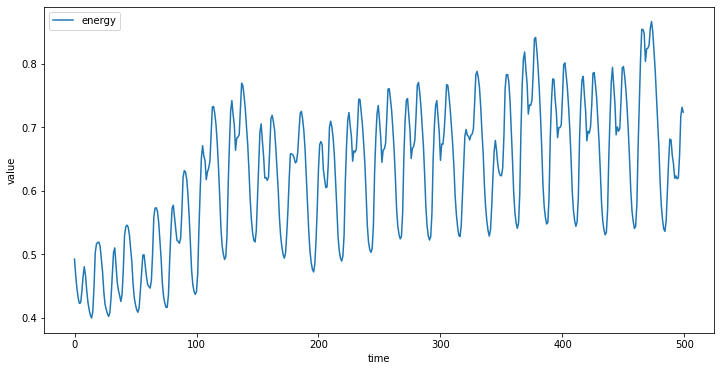

In [10]:
#データの表示
#plt.plot(data[:500, 0], label="hour")
plt.plot(data[:500, 1], label="energy")
plt.xlabel('time')
plt.ylabel('value')
plt.legend()
plt.show()

## 学習データの作成

In [11]:
# 入力データ, 正解データを作成
n_prev = 100      # 入力データ長 # 100づつのデータにする。 # この長さ分バックプロパゲーションが有効になる。
t_prev = 0        # 何サンプル先を予測するか　(0:次のサンプル)

X, Y = [], []
for i in range(len(data)-n_prev-t_prev):
    X.append(data[i:i+n_prev])             # 入力データ: i番目からi+n_prev-1番目のデータ # 確かにこれはなんで窓みたいな感じでデータをスライドさせていれるのか？ この長さ分過去バックプロパゲーションが有効になる。
    Y.append(data[i+n_prev+t_prev, 1:])   # 正解データ

X = np.array(X)
Y = np.array(Y)
print(X.shape, Y.shape)

(26180, 100, 2) (26180, 1)


In [12]:
# 訓練データと評価用データを分割 # 前半８割は
train_ratio = 0.8           # 訓練データの割合

split_pos = int( len(X) * train_ratio )     # 分割位置
X_train = X[0:split_pos]
Y_train = Y[0:split_pos]
X_test = X[split_pos:]
Y_test = Y[split_pos:]

print('X_train shape: ', X_train.shape )      # (サンプル, 時間, データ次元)
print('X_test shape: ',  X_test.shape )       # (サンプル, データ次元)
print('Y_train shape: ', Y_train.shape )
print('Y_test shape: ', Y_test.shape )

X_train shape:  (20944, 100, 2)
X_test shape:  (5236, 100, 2)
Y_train shape:  (20944, 1)
Y_test shape:  (5236, 1)


## モデル作成と学習

In [13]:
# モデル作成
model = Sequential()  
model.add(SimpleRNN(15, input_shape=(None, 2), return_sequences=False))  # 再帰パーセプトロンを１５。再帰以外を後段に入れる場合はFalseを入れる。
model.add(Activation('relu'))
model.add(Dense(1, activation='linear'))  

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 15)                270       
_________________________________________________________________
activation_1 (Activation)    (None, 15)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 16        
Total params: 286
Trainable params: 286
Non-trainable params: 0
_________________________________________________________________


In [14]:
# 学習パラメータの設定
model.compile(loss="mean_squared_error", optimizer="adam")

# モデルの学習
batch_size = 50         # バッチサイズ
epochs = 20           # エポック数 # やってみて足りなかったら増やすくらいでOK
history = model.fit(X_train, Y_train,
                    batch_size=batch_size, epochs=epochs,
                    validation_data=(X_test, Y_test))

Train on 20944 samples, validate on 5236 samples
Epoch 1/20
20944/20944 [==============================] - 46s 2ms/step - loss: 0.0255 - val_loss: 0.0013
Epoch 2/20
20944/20944 [==============================] - 39s 2ms/step - loss: 0.0011 - val_loss: 7.7949e-04
Epoch 3/20
20944/20944 [==============================] - 47s 2ms/step - loss: 7.3777e-04 - val_loss: 5.5475e-04
Epoch 4/20
20944/20944 [==============================] - 39s 2ms/step - loss: 5.6098e-04 - val_loss: 4.1922e-04
Epoch 5/20
20944/20944 [==============================] - 37s 2ms/step - loss: 4.4569e-04 - val_loss: 3.2659e-04
Epoch 6/20
20944/20944 [==============================] - 37s 2ms/step - loss: 3.7860e-04 - val_loss: 3.0091e-04
Epoch 7/20
20944/20944 [==============================] - 36s 2ms/step - loss: 3.3969e-04 - val_loss: 2.9480e-04
Epoch 8/20
20944/20944 [==============================] - 35s 2ms/step - loss: 3.0432e-04 - val_loss: 2.5074e-04
Epoch 9/20
20944/20944 [==============================] - 4

## 学習結果の評価

Test loss: 0.00016899259007344488


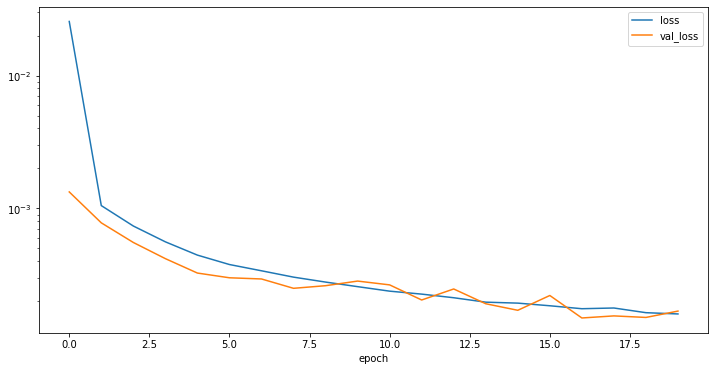

In [15]:
# 学習結果の評価
loss = model.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', loss)

# 学習誤差グラフ
plt.plot(history.history['loss'], label="loss")
plt.plot(history.history['val_loss'], label="val_loss")
plt.yscale('log')
plt.legend()
plt.xlabel('epoch')
plt.show()

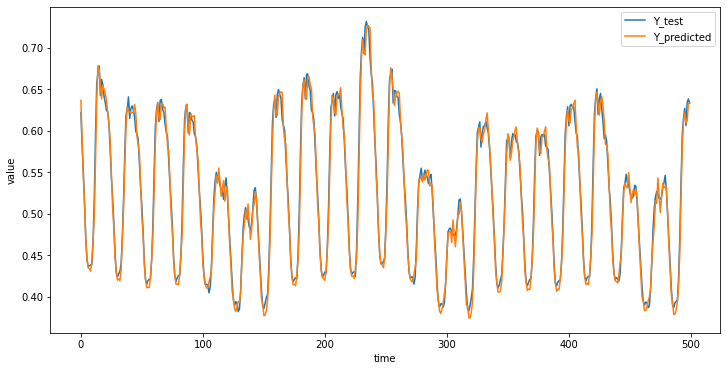

In [16]:
# 元データと予測結果のグラフ表示
Y_predicted = model.predict(X_test)

plt.plot(Y_test[0:500], label="Y_test")
plt.plot(Y_predicted[0:500], label="Y_predicted")
plt.xlabel('time')
plt.ylabel('value')
plt.legend()
plt.show()